In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import read_data
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

%matplotlib inline
matplotlib.rcParams["figure.facecolor"] = "white"
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

save_fig = lambda x: plt.savefig("figs/" + x, bbox_inches='tight')


In [2]:
data = pd.read_excel("metro-data.xlsx")
data0 = data.to_numpy()


In [3]:
data0 = data0[1:, :]
for i in range(data0.shape[0]):
    for j in range(data0.shape[1]):
        if type(data0[i, j]) != str and np.isnan(data0[i, j]):
            data0[i, j] = 0


In [4]:
data_pob = []
for i in range(data0.shape[0]):
    if data0[i, 2] == "POB" or data0[i, 2] == "CAT":
        date = datetime.strptime(data0[i, 1], "%d.%m.%Y")
        data_pob.append(data0[i, [1] + list(range(4, data0.shape[1]))])
        data_pob[-1][0] = date
data_pob = np.array(data_pob)


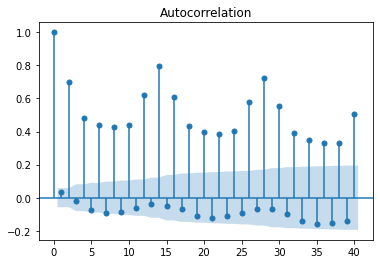

In [5]:
sm.graphics.tsa.plot_acf(data_pob[:, 2], lags=40)
plt.show()


In [14]:
data_per_month = {}
for data in data_pob:
    month = data[0].month
    if month in data_per_month:
        data_per_month[month].append(data[1:].mean())
    else:
        data_per_month[month] = [data[1:].mean()]


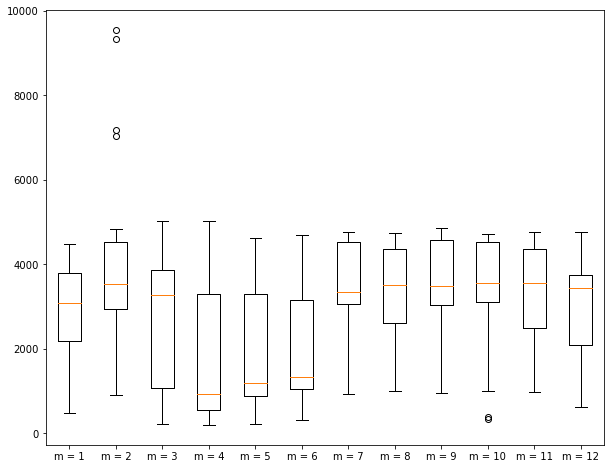

In [15]:
xticks = []
data_list = []
for month in data_per_month:
    data_list.append(data_per_month[month])
    xticks.append("m = " + str(month))

fig = plt.figure(1, figsize=(10, 8))
ax = fig.add_subplot(111)
ax.boxplot(data_list)
ax.set_xticklabels(xticks)
plt.show()

In [16]:
used_data = []
selected_months = [4, 5, 6]
for month in selected_months:
    used_data += data_per_month[month]


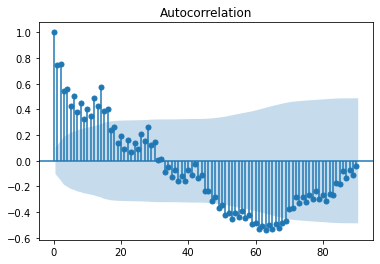

In [21]:
sm.graphics.tsa.plot_acf(used_data, lags=90)
plt.show()


In [5]:
# Tukey statistical depth
def depth_tukey(point, data, n):
    r, c = data.shape
    u = np.random.normal(size=(c, n))

    # Calculate scalars
    scalar = data.dot(u)
    scalar2 = point.dot(u)
    replic = np.ones((r, 1)).dot(scalar2)
    diff = scalar - replic
    diff_indicator = (diff > 0).astype(np.int)

    return diff_indicator.mean(axis=0).min()

# Finding depth of each point
def remove_outliers(data):
    depths = []
    for i in range(data.shape[0]):
        depth = depth_tukey(data[i, :].reshape(1, -1), data, 300)
        depths.append(depth)

    depths = np.array(depths)
    new_data = data.tolist()
    depths_aux = depths.copy()
    max_depth = depths.max()
    indexes = []
    for i in range(int(0.15 * len(depths))):
        min_index = depths_aux.argmin()
        indexes.append(min_index)
        depths_aux[min_index] = max_depth

    indexes = list(sorted(indexes, reverse=True))
    for i in indexes:
        new_data.pop(i)

    return np.array(new_data)


In [26]:
data_no_out = remove_outliers(data_pob[:, 1:])


(699, 21)


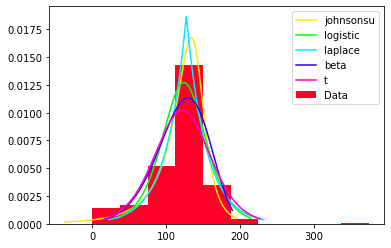

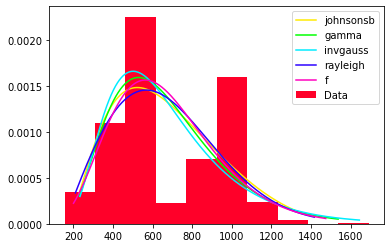

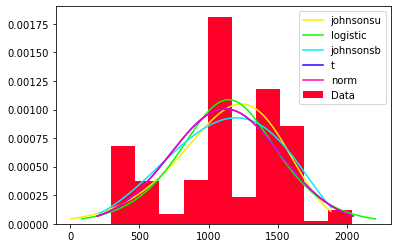

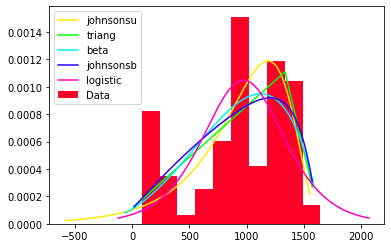

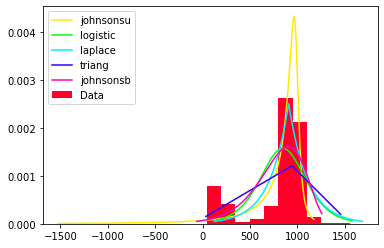

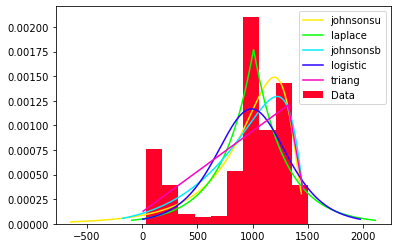

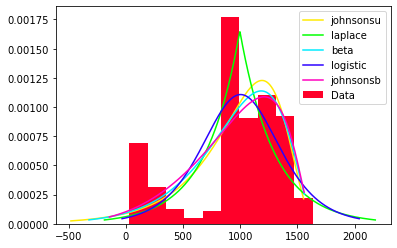

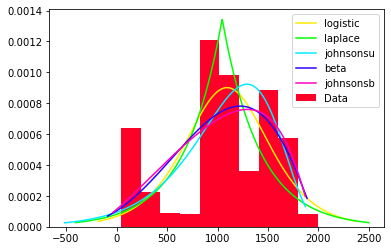

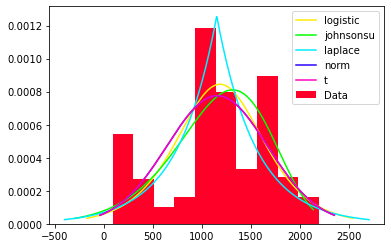

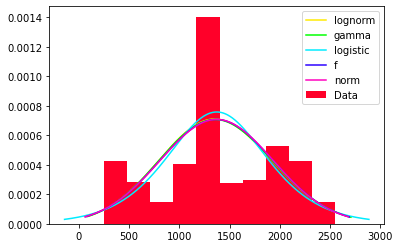

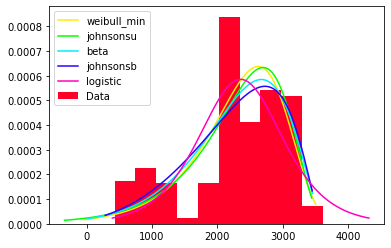

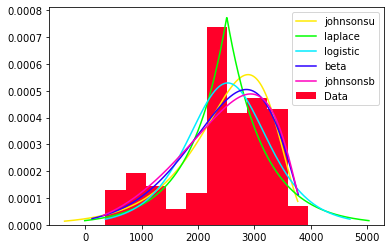

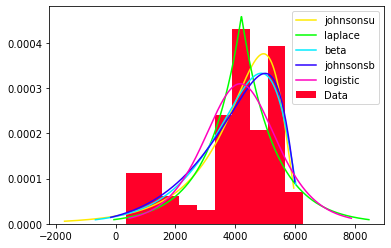

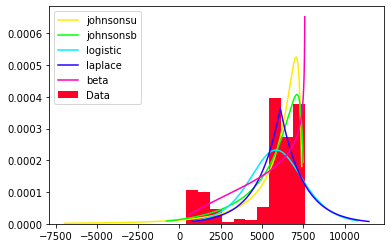

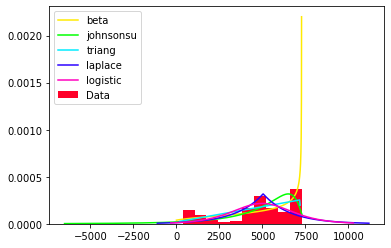

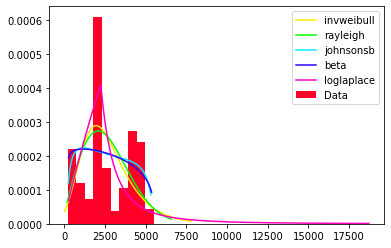

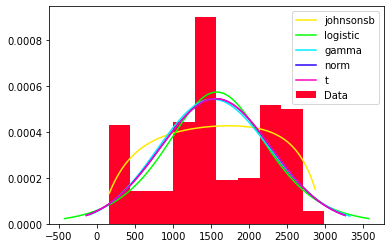

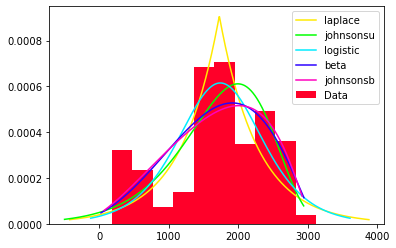

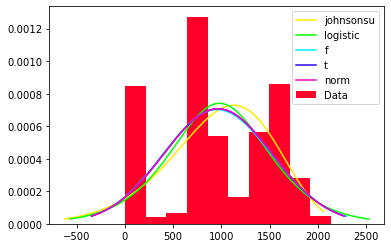

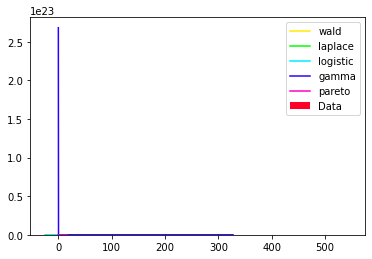

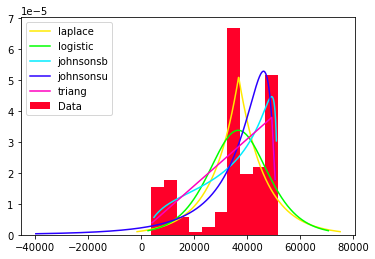

In [28]:
da = read_data.DataAnalysis()
print(data_no_out.shape)
for i in range(data_no_out.shape[1]):
    da.set_data(data_no_out[:, i])
    da.fitting_test(write=True, name_file="{}-fitting.txt".format(i + 4), plot=True, rank=5)
